In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,recall_score,precision_score,f1_score,fbeta_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Flatten,Conv1D, Embedding,GlobalMaxPooling1D,Input
from tensorflow.keras.models import Sequential

%pip install Sastrawi
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share

In [2]:
combined_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/dataset_combined_new - dataset_combined_new.csv', encoding='utf-8', index_col=False)
train_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/train.csv')
val_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/val.csv')
test_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/test.csv')

In [3]:
train_data['label'].value_counts()

label
0    1997
1     739
Name: count, dtype: int64

In [4]:
test_data['label'].value_counts()

label
0    250
1     92
Name: count, dtype: int64

In [5]:
combined_data.shape

(3895, 2)

In [6]:
#check text datatypes
combined_data.dtypes

text     object
label     int64
dtype: object

In [7]:
#Ensure string datatypes
combined_data['text']=combined_data['text'].astype(str)
train_data['text']=train_data['text'].astype(str)
val_data['text']=val_data['text'].astype(str)
test_data['text']=test_data['text'].astype(str)

In [8]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu','gw','lu','lo','gua']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"[^A-Za-z ]", "", text.lower())  # Remove non-alphabet characters
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if word not in stopwords]
    return " ".join(word_list) 

In [9]:
combined_data['text'] = combined_data['text'].apply(preprocess_text)
train_data['text']=train_data['text'].apply(preprocess_text)
val_data['text']=val_data['text'].apply(preprocess_text)
test_data['text']=test_data['text'].apply(preprocess_text)

In [10]:
texts = combined_data['text'].values
labels = combined_data['label'].values

train_texts = train_data['text'].values
train_labels = train_data['label'].values

val_texts = val_data['text'].values
val_labels = val_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values

In [11]:
texts

array(['game slot online terpercaya winning sering kasih bonus',
       'raffi situs resmi slot gacor anti rungkad terbaik bandar togel terpercaya indonesia',
       'sendok bonus deposit redeposit', ..., 'kocaaakkkkk', 'panikk',
       'malah end'], dtype=object)

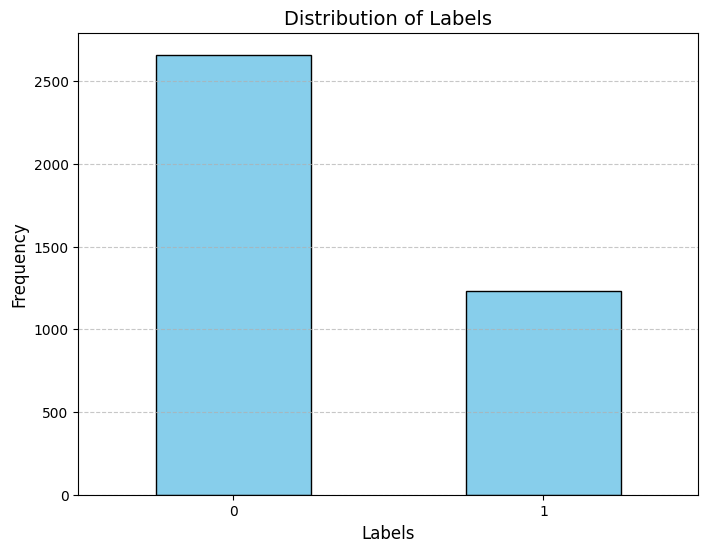

In [12]:
label_counts = combined_data['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Labels', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

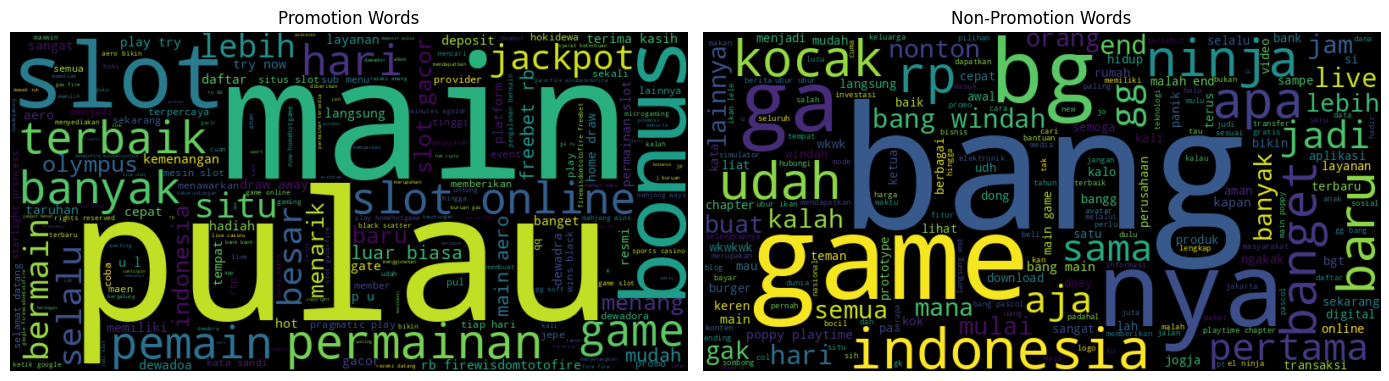

In [13]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate the texts by class
promotion_texts = texts[labels == 1]
non_promotion_texts = texts[labels == 0]

# Generate wordcloud for each class
promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(promotion_texts))
non_promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(non_promotion_texts))

# Plot the wordclouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(promotion_wordcloud, interpolation='bilinear')
axes[0].set_title("Promotion Words")
axes[0].axis("off")

axes[1].imshow(non_promotion_wordcloud, interpolation='bilinear')
axes[1].set_title("Non-Promotion Words")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [14]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def tokenize_function(texts):
    return tokenizer(texts,padding=True,truncation=True, return_tensors='tf', max_length=512)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
#x_train,x_temp,y_train,y_temp=train_test_split(texts,labels, test_size=0.2, random_state=42,stratify=labels)
#x_test,x_val,y_test,y_val=train_test_split(x_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [16]:
train_texts_tokens = tokenize_function(train_texts.tolist())
val_texts_tokens = tokenize_function(val_texts.tolist())
test_texts_tokens = tokenize_function(test_texts.tolist())


In [17]:
from transformers import TFAutoModel

bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p1")
bert_model.trainable = False  # freeze BERT weights


tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [18]:
def get_bert_embeddings(tokenized_data, batch_size=32):
    embeddings = []
    for i in range(0, len(tokenized_data['input_ids']), batch_size):
        batch_input_ids = tokenized_data['input_ids'][i:i+batch_size]
        batch_attention_mask = tokenized_data['attention_mask'][i:i+batch_size]

        # Get BERT embeddings for each batch
        batch_outputs = bert_model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            training=False
        ).last_hidden_state

        embeddings.append(batch_outputs)

    return tf.concat(embeddings, axis=0)

In [19]:
train_embeddings = get_bert_embeddings(train_texts_tokens)
val_embeddings = get_bert_embeddings(val_texts_tokens)
test_embeddings = get_bert_embeddings(test_texts_tokens)


In [20]:
model = Sequential([
    Input(shape=(128,768)), 
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),

    BatchNormalization(),

    Conv1D(filters=128, kernel_size=5, activation='relu'),

    GlobalMaxPooling1D(),

    Dense(128, activation='relu'),

    Dropout(0.5),
    
    Dense(64, activation='relu'),

    Dropout(0.5),

    Dense(32, activation='relu'),

    Dropout(0.5),

    Dense(1, activation='sigmoid')

])


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 126, 64)             │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 122, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,745 (842.75 KB)

 Trainable params: 215,617 (842.25 KB)

 Non-trainable params: 128 (512.00 B)

None


In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [23]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [24]:
history=model.fit(train_embeddings,train_labels,epochs=100,validation_data=(val_embeddings,val_labels),batch_size=64,callbacks=[early_stopping],class_weight=class_weights)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.4153 - loss: 1.5068 - val_accuracy: 0.2711 - val_loss: 0.8427
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4265 - loss: 1.2992 - val_accuracy: 0.2770 - val_loss: 0.7959
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.4501 - loss: 1.0600 - val_accuracy: 0.3469 - val_loss: 0.7428
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.4887 - loss: 0.9781 - val_accuracy: 0.4636 - val_loss: 0.7061
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5048 - loss: 0.9256 - val_accuracy: 0.5773 - val_loss: 0.6688
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5400 - loss: 0.8518 - val_accuracy: 0.6706 - val_loss: 0.6348
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5332 - loss: 0.8597 - val_accuracy: 0.7143 - val_loss: 0.6103
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5414 - loss: 0.7775 - val_accuracy: 

In [25]:
pred=model.predict(test_embeddings)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [26]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score

y_probs = pred.flatten()

precisions, recalls, thresholds = precision_recall_curve(test_labels, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {f1s[best_idx]:.4f}")

ap_score = average_precision_score(test_labels, y_probs)
print(f"Average Precision (AP) Score: {ap_score:.4f}")


Best Threshold: 0.5789
Best F1-Score: 0.9560
Average Precision (AP) Score: 0.9794


Accuracy Score: 0.9766
Recall Score: 0.9457
Precision Score: 0.9667
F1 Score: 0.9560
Fbeta Score: 0.9624
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.99      0.98       250
           1       0.97      0.95      0.96        92

    accuracy                           0.98       342
   macro avg       0.97      0.97      0.97       342
weighted avg       0.98      0.98      0.98       342

Confusion Matrix:



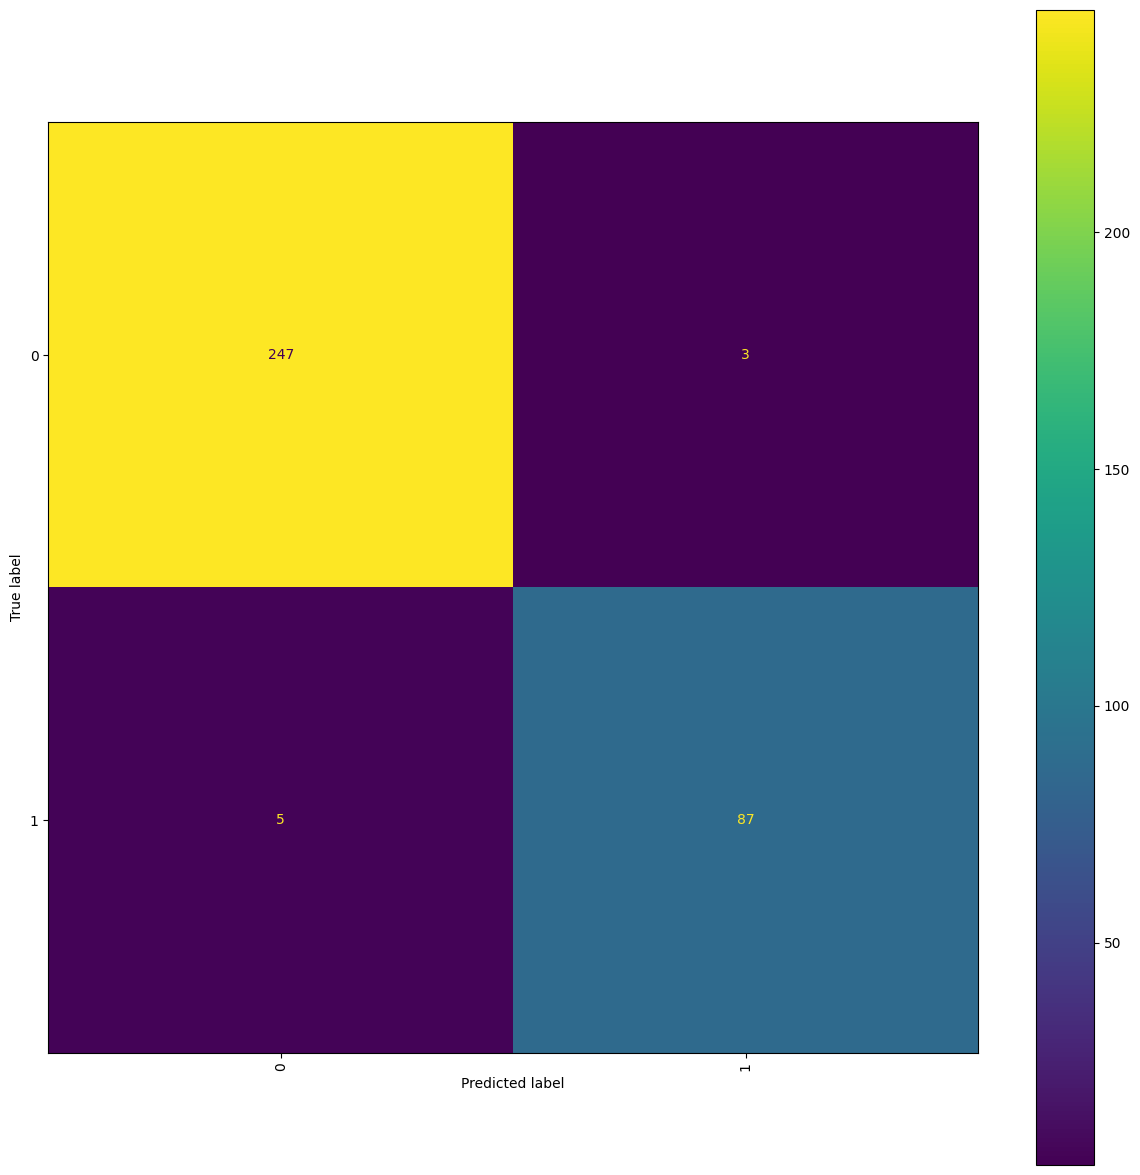

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
#pred_labels = (pred > 0.5).astype(int)  
pred_labels = [0 if pred < best_threshold else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(test_labels, pred_labels):.4f}")
print(f"Recall Score: {recall_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"Precision Score: {precision_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"F1 Score: {f1_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"Fbeta Score: {fbeta_score(test_labels, pred_labels,beta=0.5,average='binary',pos_label=1):.4f}")

print(f"Classification Report: {classification_report(test_labels, pred_labels)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, pred_labels))

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [28]:
def predict_sentiment(text):
    use_text = [preprocess_text(t) for t in text]
    use_text=tokenize_function(use_text)
    
    use_embeddings=get_bert_embeddings(use_text) 
    
    pred = model.predict(use_embeddings)
    pred_labels = (pred > 0.5).astype(int)
    pred_labels = pred_labels.flatten() 
    #pred_labels = tf.argmax(pred.logits, axis=1)
    
    label_type = ['NotPromotion', 'Promotion']
    pred_labels = [label_type[i] for i in pred_labels]
    
    for index, pred in enumerate(pred_labels):
        print(f"{text[index]}: {pred}")

In [29]:
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar."
]
predict_sentiment(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
Aku adalah seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov: NotPromotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang di xxtoto: Promotion
top up di kantorbola pasti gampang menangnya: Promotion
gratis koin buruan topup di agencasinoindonesia: Promotion
gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda: Promotion
DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣: Promotion
DEWA-DORA tuh situs yang paling gampang narik tiap hari! 😖 😣: Promotion
Gua setia maen di DEWADORA, tempat terbaik!: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.: Promotion
